# Hazard: WildFire

This class is used to model the wildfire hazard using the historical data available and creating synthetic fires which are summarized into event years to establish a comprehensiv probabilistic risk assessment. 

The historical data used comes from the [Fire Information for Resource Management System (FIRMS)](https://earthdata.nasa.gov/earth-observation-data/near-real-time/firms/about-firms). They collect temperatures from the following satellite instruments:

    - Moderate Resolution Imaging Spectroradiometer  (MODIS): Near real time or standard quality data with 1 km resolution. Data available from November 2000 to present.

    - Visible Infrared Imaging Radiometer Suite (VIIRS): Near real time data with 0.375 km resolution. Data available from 20 January 2012 to present.

The data should be obtained at https://firms.modaps.eosdis.nasa.gov/download/ and saved as .csv file. Approximatly 15 min after submitting the request, the data can be downloaded by checking the request status. 

The `WildFire` class inherits from the `Hazard` class and has an associated hazard type `WF`. It provides a `set_hist_fire_FIRMS()` method which enables to fill the hazard with historical events, a `set_hist_fire_seasons_FIRMS()` method which aggregates historic events to event years, and a `set_proba_fire_seasons()` method which generates random event years.

Some additional notes:
- in contrast to other hazards (i.e. TC) there's no clear definition for "a wildfire event". While some countries (i.e. US, Australia) provide very detailed reports, other's (i.e. Chile, Indonesia) rather provide information on the whole fire season. Thus, we produce probabilistic fire seasons rather than single events to ensure global consistency. However, for case studies or calibration studies, identification of single fire events is still of importance. Thus, we differentiate in the hazard tag: 'WFsingle' for individual fires as recognized by the algorithm, 'WFseason' for whole fire seasons.

- Wildfires are hazards with a huge societal component - in many cases humans are not only responisble for starting one, but also for ending it (fire fighting). This means, that worst case scenarios (i.e. a wild fire spreading to down town Los Angeles) are less likely, as compared to TC risk, where it is highly likely that a stong TC strikes Manila and people have no chance to prevent that from happening. Accordingly, the probabilistic wildfires come with an even larger uncertainty than other hazard as social behaviour have a major impact on wildfires.

- In our default version for creating probabilistic fire seasons, we rely fully on past data. Thus, in the default, this module is not suited to conduct studies on climate change risk. However, the generation of synthetic fire seasons can be manipulated.

- We are currently working on improving the generation of proabilistic events.

### This tutorial describes
- How past fires are computed
- How past fire seasons are computed
- How probabilistic fire seasons are generated

## HISTORICAL FIRES

A fire is defined as an event when the temporal and spatial distance of the burning centroids is close enough. There are two parameters which define the "closeness":

    - days_thres (int): temporal distance in days. Default: 2.
    - clus_thres (int): factor to multiply to the centroids resolution. Used to determine the cluster maximum distance between two centroids. Default: 15.
    
These parameters are stored in the DataClass `WF.FirmsParams`

In June 2017, Portugal was hit by a series of deadly wild fires which led to 66 fatalities, more than 200 mn. USD damages and 45'000 ha burned area. With `set_hist_fire_FIRMS()` we can model past fire such as the ones in Portugal in 2017. The method takes FIRMS data as a dataframe (`pd.df`) as input. If no `Centroids` are defined, the method automatically defines centroids in line with the spatial extent of the FIRMS data. Hazard resolution can be modified using parameter `centr_res_factor`.


2021-06-28 14:28:05,487 - climada.hazard.centroids.centr - INFO - Convert centroids to GeoSeries of Point shapes.


/Users/sam/opt/anaconda3/envs/climada_env/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


2021-06-28 14:28:07,804 - climada.hazard.wildfire - INFO - Remaining fires to identify: 0.
2021-06-28 14:28:07,827 - climada.hazard.wildfire - INFO - Computing intensity of 7 fires.
2021-06-28 14:28:07,862 - climada.hazard.wildfire - INFO - Returning 7 fires that impacted the defined centroids.


<GeoAxesSubplot:title={'center':'WFsingle max intensity at each point'}>

<Figure size 432x288 with 0 Axes>

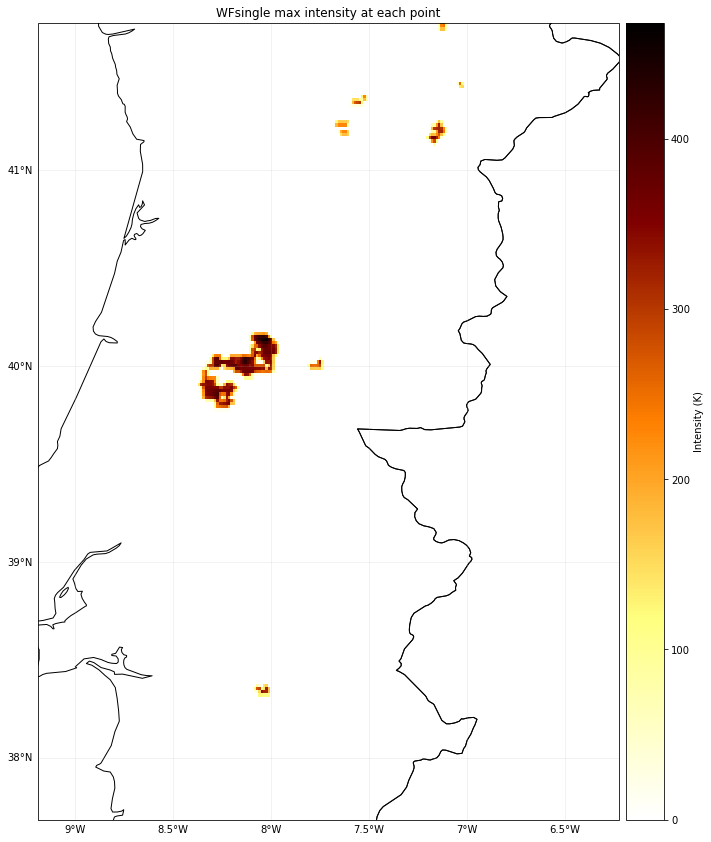

In [11]:
# Fires in Portugal 2017
import os
import pandas as pd

from climada.util.constants import DEMO_DIR
from climada.hazard import WildFire

import matplotlib.pyplot as plt
plt.set_cmap('afmhot_r') # set colormap

# Data downloaded for MODIS
d_path = os.path.join(DEMO_DIR, "Portugal_firms_June_2017.csv")

# read data
firms = pd.read_csv(d_path) # FIRMS data as pandas dataframe

# set up wildfire
wf_pt = WildFire()
wf_pt.set_hist_fire_FIRMS(firms, centr_res_factor=1./2.5) # we decrease the hazard resolution to 2.5 km

# plot the maximum intensity of all fires at each centroid
wf_pt.plot_intensity(event=0)

We can focus on the region around Coimbra where the most deadly fire occured.

A given set of points or grid can be provided using the `Centroids` class. The events will be interpolated to the provided coordinates.

2021-06-28 14:28:17,132 - climada.hazard.wildfire - INFO - Remaining fires to identify: 0.
2021-06-28 14:28:17,153 - climada.hazard.wildfire - INFO - Computing intensity of 7 fires.
2021-06-28 14:28:17,182 - climada.hazard.wildfire - INFO - Returning 2 fires that impacted the defined centroids.


<GeoAxesSubplot:title={'center':'WFsingle max intensity at each point'}>

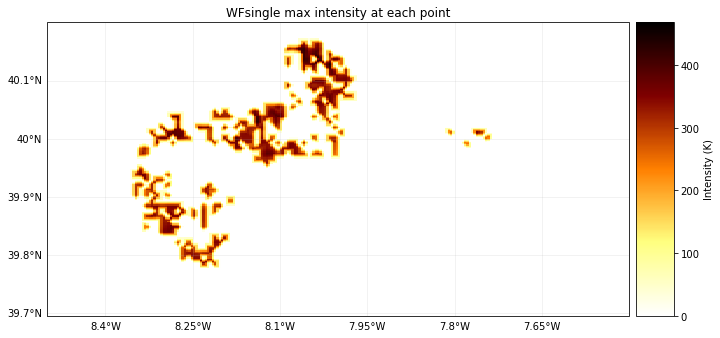

In [12]:
from climada.hazard import Centroids
from climada.util.constants import ONE_LAT_KM

# focus on Coimbra region with 1.0 km resolution (MODIS resolution)
res = 1.0/ONE_LAT_KM
centr_zoom = Centroids()
centr_zoom.set_raster_from_pnt_bounds((-8.5, 39.7, -7.5, 40.2), res)

wf_zoom = WildFire()
wf_zoom.set_hist_fire_FIRMS(firms, centroids=centr_zoom)
wf_zoom.plot_intensity(0)

See more infos on [Wikipedia](https://en.wikipedia.org/wiki/June_2017_Portugal_wildfires) around the fire.

## HISTORICAL FIRE SEASONS

`set_hist_fire_seasons_FIRMS()` generates historic fire seasons.

These fire seasons can later be compared to the probabilistic event years for a seamless risk analysis.
Note:
- all the underlying events of a year are merged into one single event which is saved.
- The original events, that result from the clustering are not kept in order to save space. However, this can be done setting the parameter `keep_all_events` to true.
- If single fires are already calculated and assigned to centroids, they can be aggregated to seasons using `summarize_fires_to_seasons()` 

2021-06-28 14:28:27,823 - climada.hazard.wildfire - INFO - Setting up historical fires for year set.
2021-06-28 14:28:27,903 - climada.hazard.centroids.centr - INFO - Convert centroids to GeoSeries of Point shapes.


/Users/sam/opt/anaconda3/envs/climada_env/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


2021-06-28 14:28:44,160 - climada.hazard.wildfire - INFO - Setting up historical fire seasons 2016.
2021-06-28 14:28:45,242 - climada.hazard.wildfire - INFO - Remaining fires to identify: 3388.
2021-06-28 14:28:45,595 - climada.hazard.wildfire - INFO - Remaining fires to identify: 11.
2021-06-28 14:28:45,644 - climada.hazard.wildfire - INFO - Remaining fires to identify: 0.
2021-06-28 14:28:46,141 - climada.hazard.wildfire - INFO - Computing intensity of 113 fires.
2021-06-28 14:28:47,396 - climada.hazard.wildfire - INFO - Returning 113 fires that impacted the defined centroids.
2021-06-28 14:28:48,974 - climada.hazard.wildfire - INFO - Setting up historical fire seasons 2017.
2021-06-28 14:28:50,087 - climada.hazard.wildfire - INFO - Remaining fires to identify: 2392.
2021-06-28 14:28:50,574 - climada.hazard.wildfire - INFO - Remaining fires to identify: 210.
2021-06-28 14:28:50,705 - climada.hazard.wildfire - INFO - Remaining fires to identify: 0.
2021-06-28 14:28:51,569 - climada.ha

<GeoAxesSubplot:title={'center':'Event ID 3: 2018'}>

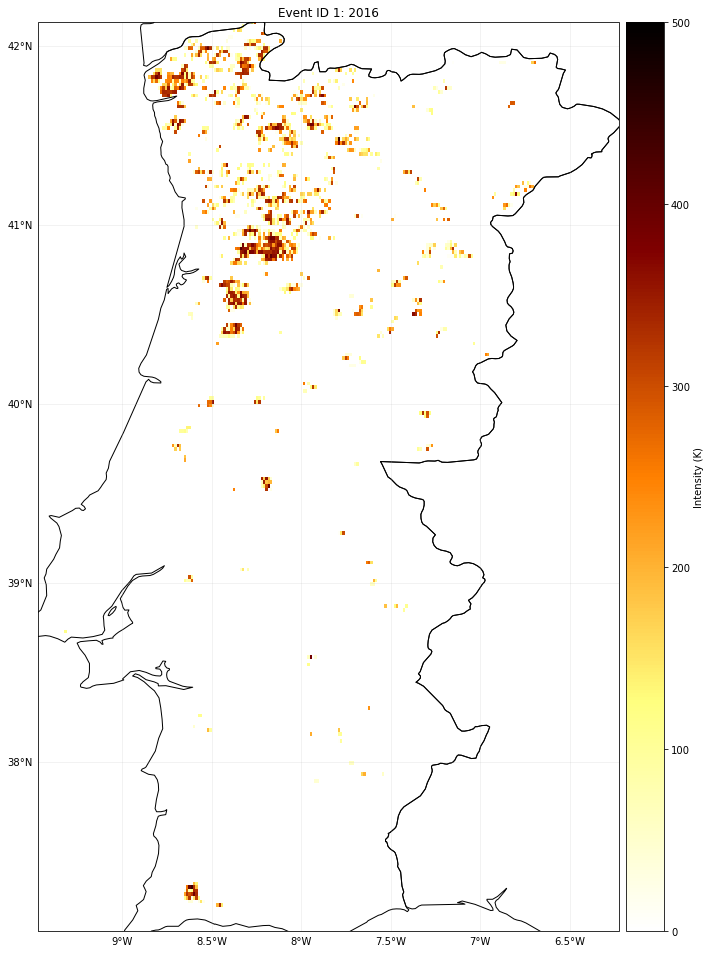

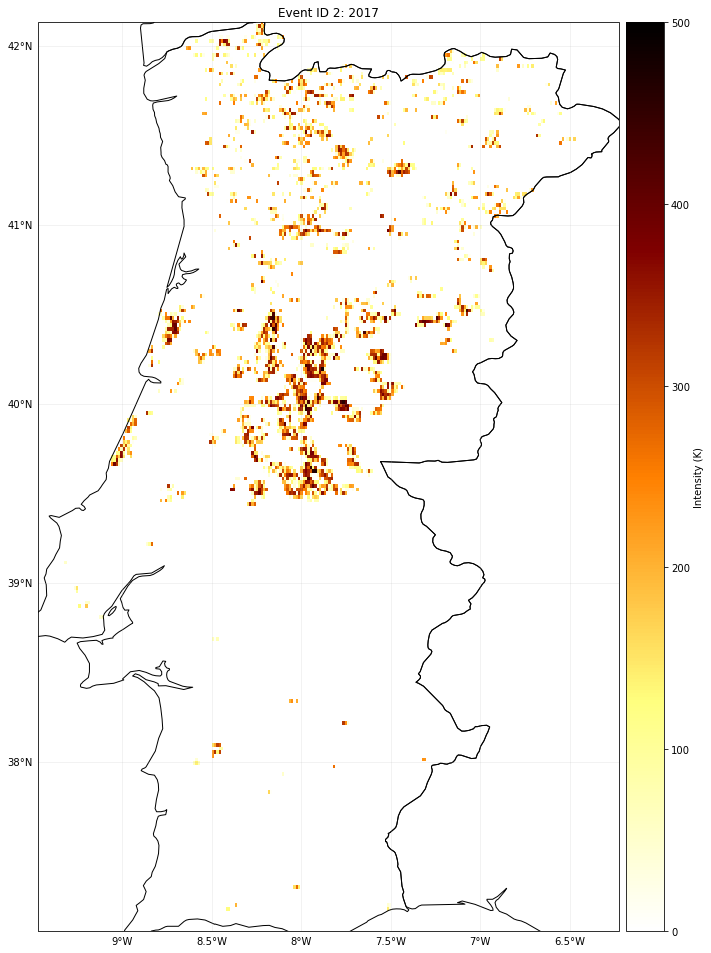

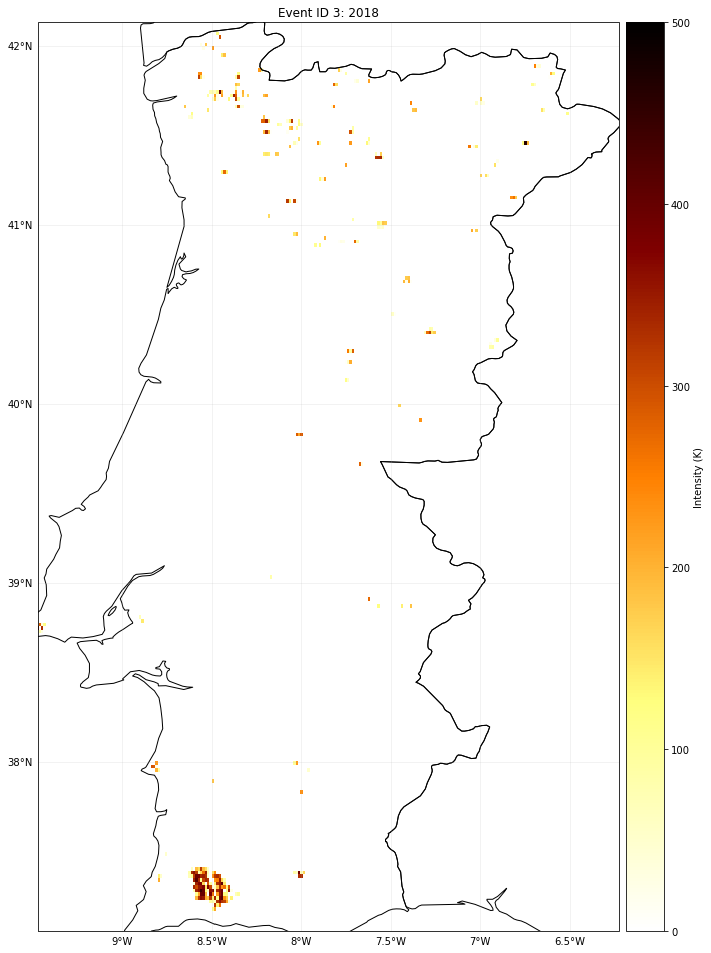

In [13]:
# load FIRMS data for 2016-2018 an select main land Portugal only
firms_seasons = pd.read_csv(os.path.join(DEMO_DIR, "Portugal_firms_2016_17_18_MODIS.csv"))
firms_seasons = firms_seasons[firms_seasons['latitude']>35.]
firms_seasons = firms_seasons[firms_seasons['longitude']>-12.]


wf_years = WildFire()
wf_years.set_hist_fire_seasons_FIRMS(firms_seasons, centr_res_factor=1/1.) # we use MODIS data resolution (1 km)

print('Events are now named according to their event year:', wf_years.event_name)
print('The number of underyling events is saved as well:', wf_years.n_fires)

# plot the three fire seasons (2016, 2017, 2018)
wf_years.plot_intensity(1)
wf_years.plot_intensity(2)
wf_years.plot_intensity(3)

## PROBABILISTIC FIRE SEASONS

`set_proba_fire_seasons()` generates synthetic fire seasons.

A probabilistic fire season is generate the following way:

1. A fire propagation probability matrix is defined
        - this propagation matrix defines the probabilitiy for fire propagation on each centroid
        - if not further specified, the observation of historic data is used -> the fire can only propagate on centroids that burned in the past, including a blurr around these centroids
        - this matrix can be used to include additional information (i.e. on vegetation/land-use/elevation/population density)
        - the fire propagation probability matrix is stored in `wf.centroids.fire_propa_matrix` as an np.array and thus can be adjusted easily
        
2. A random number n of fires that occured in the probabilistic year is chosen.
        - If nothing else is specified, a random number within the range of n_fires (the number of historic events is drawn)
        - The range can also be specified in the input via the parameter `n_ignition`
        
3. n synthetic fires are generated following this logic:
        - A random fire ignition point is selected (the point needs to be burnable on the fire propagation matrix)
        - The fire is then propagated from the ignition point as a cellular automat following these rules:
        1. a neighbouring centroid to the burning centroid becomes a burning centroid with a probability p. This probability is calculated as the product of a overall fire propagation probability (default=0.21) and the centroid specific factor (which is defined on the fire propagation probability matrix)
        2. an already burning centroid becomes an ember centroid (does not propagate fire anymore but is labled as burned)
        3. an ember centroid stays an ember centroid
        4. The propagation stops when there is no burning centroid left.
        5. The temperature provided to each centroid is randomly chosen from the corresponding historical event.
        
4. These n synthetic events are summarized into a probabilistic fire season which is then appended as a new event to the historic fire seasons

This process can be computatioally expensive. Thus working on clusters might be advantageous.

Note: In the default no additional external data is included. The probabilistic event thus soley relies on past experience which likely leads to an underestimation of the current and future fire risk. The frame work allows to include climate change effects by:
   - defining the fire propagation probability matrix (using more data as described above)
   - varying the overall fire propagation probability (by i.e. linking it to a fire weather index)
   - varying the number of events per year (by i.e. linking it to a fire weather index)

2021-06-28 14:29:48,918 - climada.hazard.wildfire - INFO - Setting up probabilistic fire season with 157 fires.
2021-06-28 14:29:49,400 - climada.hazard.wildfire - INFO - Created 0 fires
2021-06-28 14:29:50,317 - climada.hazard.wildfire - INFO - Created 10 fires
2021-06-28 14:29:50,558 - climada.hazard.wildfire - INFO - Created 20 fires
2021-06-28 14:29:50,756 - climada.hazard.wildfire - INFO - Created 30 fires
2021-06-28 14:29:50,988 - climada.hazard.wildfire - INFO - Created 40 fires
2021-06-28 14:29:51,206 - climada.hazard.wildfire - INFO - Created 50 fires
2021-06-28 14:29:51,457 - climada.hazard.wildfire - INFO - Created 60 fires
2021-06-28 14:29:51,681 - climada.hazard.wildfire - INFO - Created 70 fires
2021-06-28 14:29:51,991 - climada.hazard.wildfire - INFO - Created 80 fires
2021-06-28 14:29:52,253 - climada.hazard.wildfire - INFO - Created 90 fires
2021-06-28 14:29:52,477 - climada.hazard.wildfire - INFO - Created 100 fires
2021-06-28 14:29:52,690 - climada.hazard.wildfire - 

<GeoAxesSubplot:title={'center':'Event ID 4: 4'}>

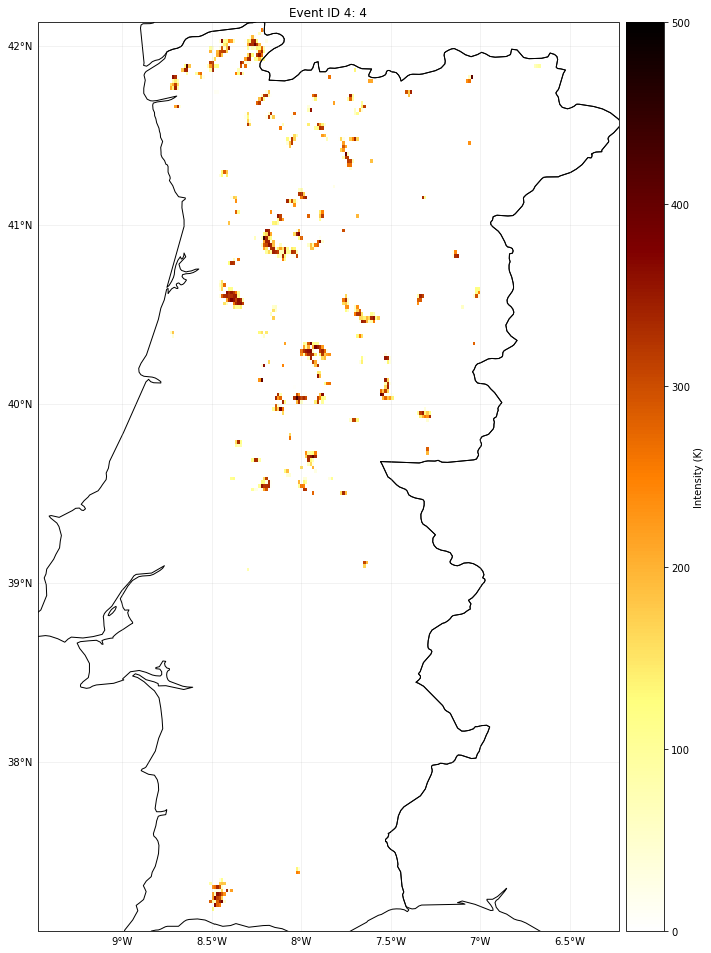

In [14]:
# generate 1 probabilistic fire season for Portugal
wf_years.set_proba_fire_seasons(n_fire_seasons=1)
print('The probabilistic event year is appended to the historic:', wf_years.event_name)

# Plot the synthetic event year
wf_years.plot_intensity(event=4)

2021-06-28 14:47:03,667 - climada.hazard.wildfire - INFO - Setting up probabilistic fire season with 147 fires.
2021-06-28 14:47:04,054 - climada.hazard.wildfire - INFO - Created 0 fires
2021-06-28 14:47:04,257 - climada.hazard.wildfire - INFO - Created 10 fires
2021-06-28 14:47:04,463 - climada.hazard.wildfire - INFO - Created 20 fires
2021-06-28 14:47:04,656 - climada.hazard.wildfire - INFO - Created 30 fires
2021-06-28 14:47:04,872 - climada.hazard.wildfire - INFO - Created 40 fires
2021-06-28 14:47:05,066 - climada.hazard.wildfire - INFO - Created 50 fires
2021-06-28 14:47:05,272 - climada.hazard.wildfire - INFO - Created 60 fires
2021-06-28 14:47:05,468 - climada.hazard.wildfire - INFO - Created 70 fires
2021-06-28 14:47:05,671 - climada.hazard.wildfire - INFO - Created 80 fires
2021-06-28 14:47:05,869 - climada.hazard.wildfire - INFO - Created 90 fires
2021-06-28 14:47:06,052 - climada.hazard.wildfire - INFO - Created 100 fires
2021-06-28 14:47:06,252 - climada.hazard.wildfire - 

<GeoAxesSubplot:title={'center':'Event ID 6: 6'}>

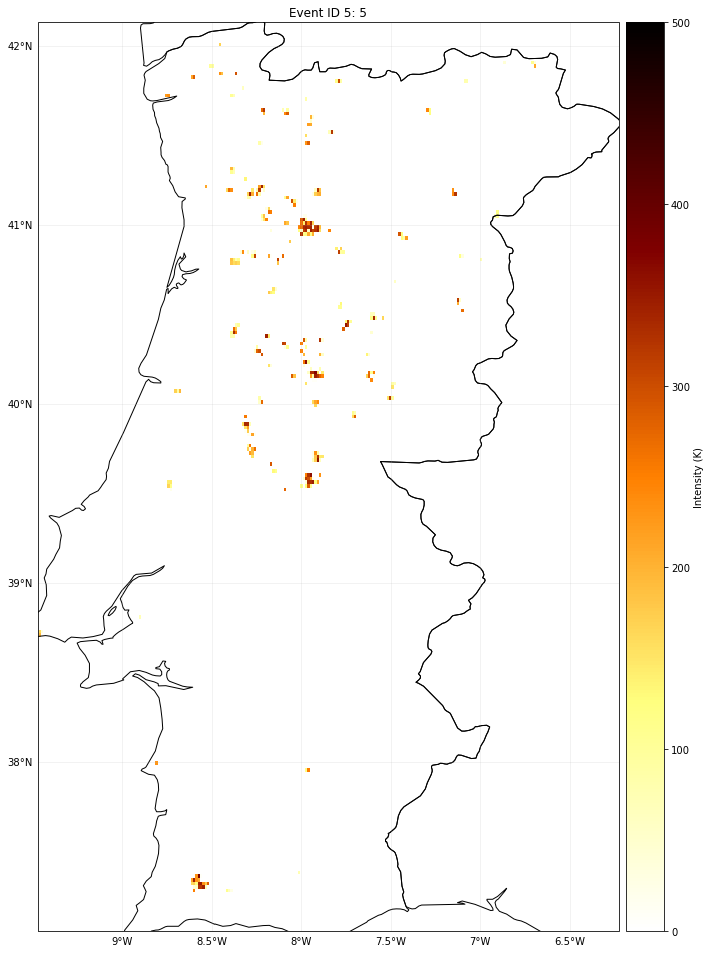

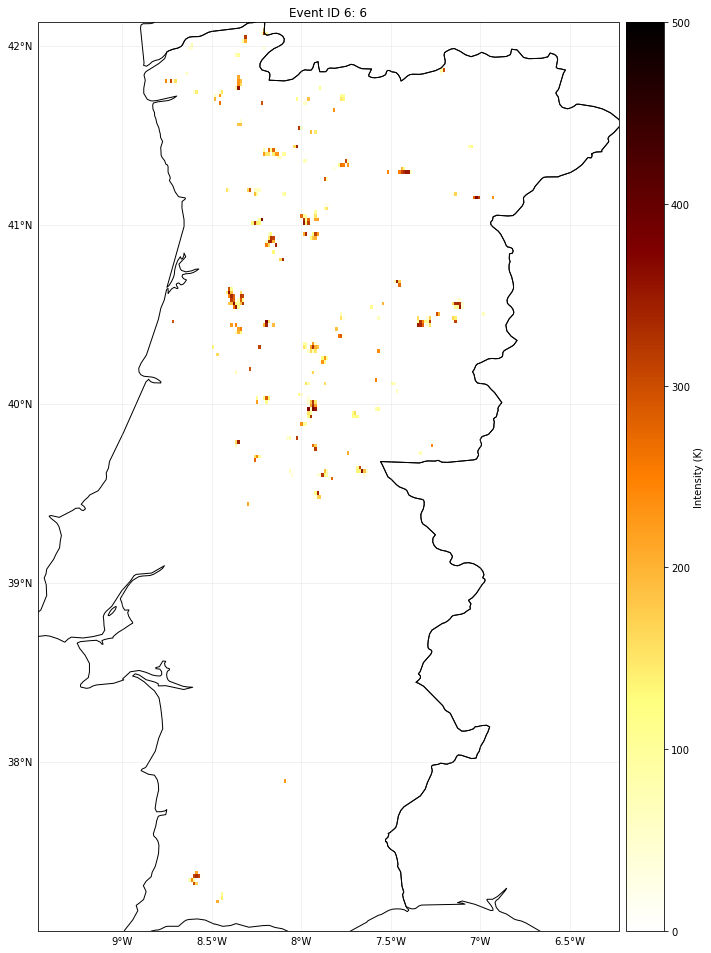

In [17]:
# The overall fire propagation probability is stored as a parameter and can be modified easily (default is 0.21)
wf_years.ProbaParams.prop_proba = 0.18
# The range of the number of events for a synthetic year can be modified when creating the event years
ign_range = [125,150]

wf_years.set_proba_fire_seasons(n_fire_seasons=2, n_ignitions=ign_range)
wf_years.plot_intensity(event=5)
wf_years.plot_intensity(event=6)

## Impact calculation

Imapct calibration follows the usual CLIMADA logic. Calibrated impact functions are available within `climada.entity.impact_funcs.wildfire`. The calibration was performed on 1, 4 and 10 km resolution (please refer to the work by Lüthi et al. (in prep.).

Note:
- as there is the ambiguity between single fires and fire seasons, the hazard.tag must be set accordingly in the impact function
- working on higher resolution often requires better resolved exposure data, especially on rural sites, where the LitPop approach is limited (i.e. an expensive wineyard does not glow in the night)